In [1]:
import os
import numpy as np
from scipy import io as sio
from matplotlib import pyplot as plt
import inspect

In [2]:
# Define a function to see the source code of a function. 
def showfunc(functiontoshow):
    print(inspect.getsource(functiontoshow))

In [3]:
import typhon as tp

In [4]:
# Set environmental variables. The ARTS path differ between my macbook and the company computer. 
if os.getcwd()[0:5] == '/User':
    tp.environ['ARTS_BUILD_PATH'] = '../../../../ARTS/arts-dev/build/'
    tp.environ['ARTS_INCLUDE_PATH'] = '../../../../ARTS/arts-dev/controlfiles/'
elif os.getcwd()[0:5] == '/home':
    tp.environ['ARTS_BUILD_PATH'] = '../../arts-dev/build/'
    tp.environ['ARTS_INCLUDE_PATH'] = '../../arts-dev/controlfiles/'

In [5]:
# Import Typhon retrieval packages. 
from typhon.retrieval.bmci import BMCI
from typhon.retrieval.mcmc import MCMC
from typhon.retrieval.qrnn import QRNN

Loading ARTS API from: ../../../../ARTS/arts-dev/build/src/libarts_api.so


Using TensorFlow backend.


In [6]:
# ARTS forward model and retrieval with OEM in development version: 
tp.arts.run_arts(controlfile='./ClearSky_1D_OEM_ARTSvdev.arts');

# Works sometimes and doesn't others. 

In [7]:
# ARTS forward model results. 
Tb_ARTS_ClearSky = tp.arts.xml.load("./ClearSky_1D_OEM_Tb.xml")

# Bosung observations, 20170930
Tb_BosungObs = tp.arts.xml.load('./Tb_radmtrL1.xml')

# Frequency
f_grid = tp.arts.xml.load('./ClearSky_1D_f_grid.xml')

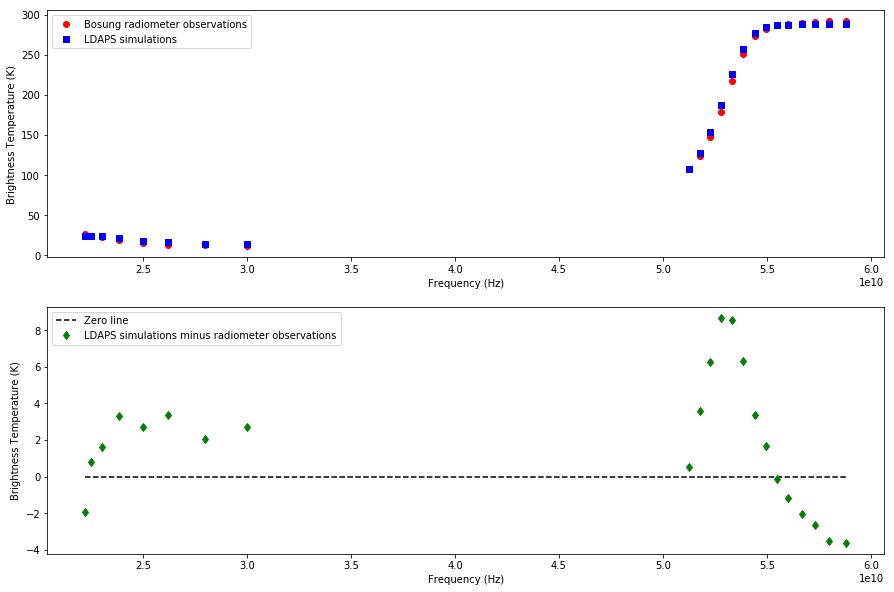

In [8]:
# Compare brightness temperatures from the simulation with the observations. 
plt.figure()

plt.subplot(2,1,1)
plt.plot(f_grid, Tb_BosungObs, 'ro', f_grid, Tb_ARTS_ClearSky, 'bs')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Brightness Temperature (K)')
plt.legend(['Bosung radiometer observations', 'LDAPS simulations'])

plt.subplot(2,1,2)
plt.plot(f_grid, np.zeros(f_grid.shape),'k--',
         f_grid, Tb_ARTS_ClearSky - Tb_BosungObs, 'gd')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Brightness Temperature (K)')
plt.legend(['Zero line','LDAPS simulations minus radiometer observations'])

plt.gcf().set_size_inches(15,10)

In [9]:
# Retrieval results
Retrieval = tp.arts.xml.load("./ClearSky_1D_OEM_retrieval_results.xml")
# Pressure grid for retrieval
p_ret_grid = tp.arts.xml.load('./ClearSky_1D_OEM_retrieval_p_grid.xml')
nRet = p_ret_grid.shape[0]

# Water VMR from 국지예보모델
VMR_H2O_GF3 = tp.arts.xml.load('./ClearSky_1D.H2O.xml')
# Temperature from 국지예보모델
t_field_GF3 = tp.arts.xml.load('./ClearSky_1D.t.xml')

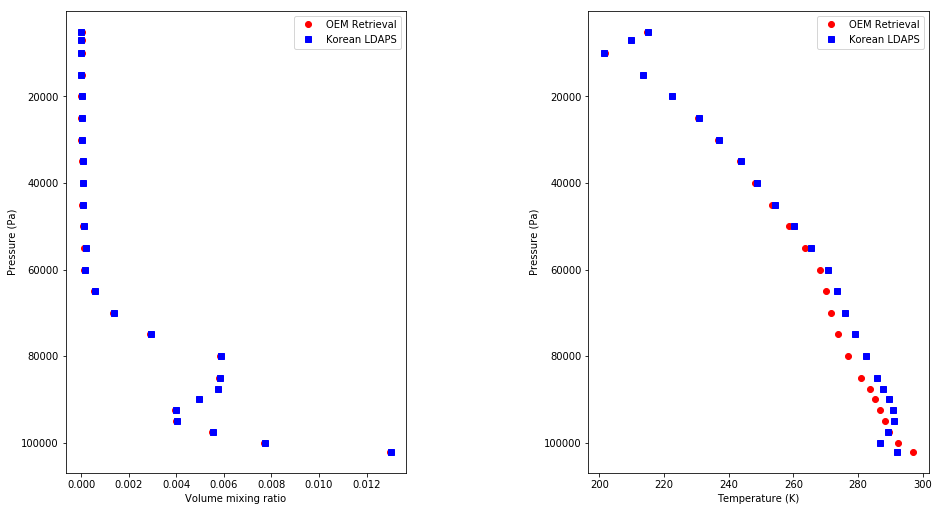

In [10]:
# Compare retrieved water VMR with the water VMR from Korean LDAPS. 
plt.figure()

plt.subplot(1,2,1)
plt.plot(Retrieval[nRet:], p_ret_grid, 'ro', np.squeeze(VMR_H2O_GF3.data), VMR_H2O_GF3.grids[0], 'bs')
plt.gca().invert_yaxis()
plt.xlabel('Volume mixing ratio')
plt.ylabel('Pressure (Pa)')
plt.legend(['OEM Retrieval', 'Korean LDAPS'])
# plt.gcf().set_size_inches(5,10)

# Compare retrieved temperatures with the temperatures from Korea LDAPS
plt.subplot(1,2,2)
plt.plot(Retrieval[0:nRet], p_ret_grid, 'ro', np.squeeze(t_field_GF3.data), VMR_H2O_GF3.grids[0], 'bs')
plt.gca().invert_yaxis()
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')
plt.legend(['OEM Retrieval', 'Korean LDAPS'])

plt.tight_layout()
plt.gcf().set_size_inches(15,8)

In [ ]:
# Quantile regression neural networks

adversarial_training = True
delta_at             = 0.05
ensemble_size        = 5
depth                = 4
width                = 64

filename = "QRNNmodels/qrnn_"
filename += str(depth) + "_" + str(width) + "_ensemble_" + str(ensemble_size)
if adversarial_training:
    filename += "_at_" + str(int(delta_at * 100))
filename    

In [ ]:
n_input = x_train.shape[1]
quantiles = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95])

qrnn_simple = QRNN(n_input, quantiles, depth = depth, width = width, ensemble_size = ensemble_size)
qrnn_simple.fit(x_train, y_train.reshape(-1, 1), sigma_noise = None,
                adversarial_training = adversarial_training,
                delta_at = delta_at,
                x_val = x_val,
                y_val = y_val,
                initial_learning_rate = 0.001,
                batch_size = 128,
                learning_rate_minimum = 1e-4,
                learning_rate_decay = 2,
                maximum_epochs = 500,
                convergence_epochs = 0)
qrnn_simple.save(filename)

In [ ]:
from typhon.arts.workspace import Workspace

In [ ]:
# Create an ARTS workspace variable. 
ws = Workspace() 

In [ ]:
%%capture
# ARTS INCLUDE files
ws.execute_controlfile("general/general.arts");
ws.execute_controlfile("general/continua.arts");
ws.execute_controlfile("general/agendas.arts");
ws.execute_controlfile("general/planet_earth.arts");

In [ ]:
%%capture
ws.execute_controlfile("TestOEM.arts");

In [ ]:
# Markov Chain Monte Carlo
variables = [[np.array([1, 2, 3]), MCMC.eval_l, MCMC.step]]
y = np.array([295, 290, 185])
ly = MCMC.eval_l

asdf = MCMC(variables,y,ly)

In [ ]:
asdf.run(ws,5)